   brewery_id             brewery_name  review_time  review_overall  \
0       10325          Vecchio Birraio   1234817823             1.5   
1       10325          Vecchio Birraio   1235915097             3.0   
2       10325          Vecchio Birraio   1235916604             3.0   
3       10325          Vecchio Birraio   1234725145             3.0   
4        1075  Caldera Brewing Company   1293735206             4.0   

   review_aroma  review_appearance review_profilename  \
0           2.0                2.5            stcules   
1           2.5                3.0            stcules   
2           2.5                3.0            stcules   
3           3.0                3.5            stcules   
4           4.5                4.0     johnmichaelsen   

                       beer_style  review_palate  review_taste  \
0                      Hefeweizen            1.5           1.5   
1              English Strong Ale            3.0           3.0   
2          Foreign / Export Stou

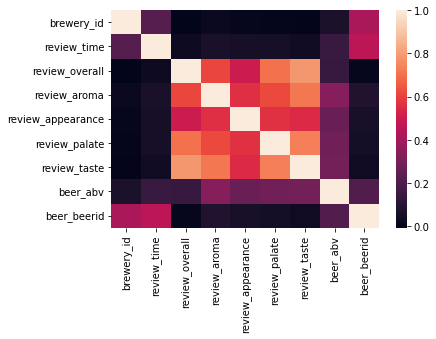

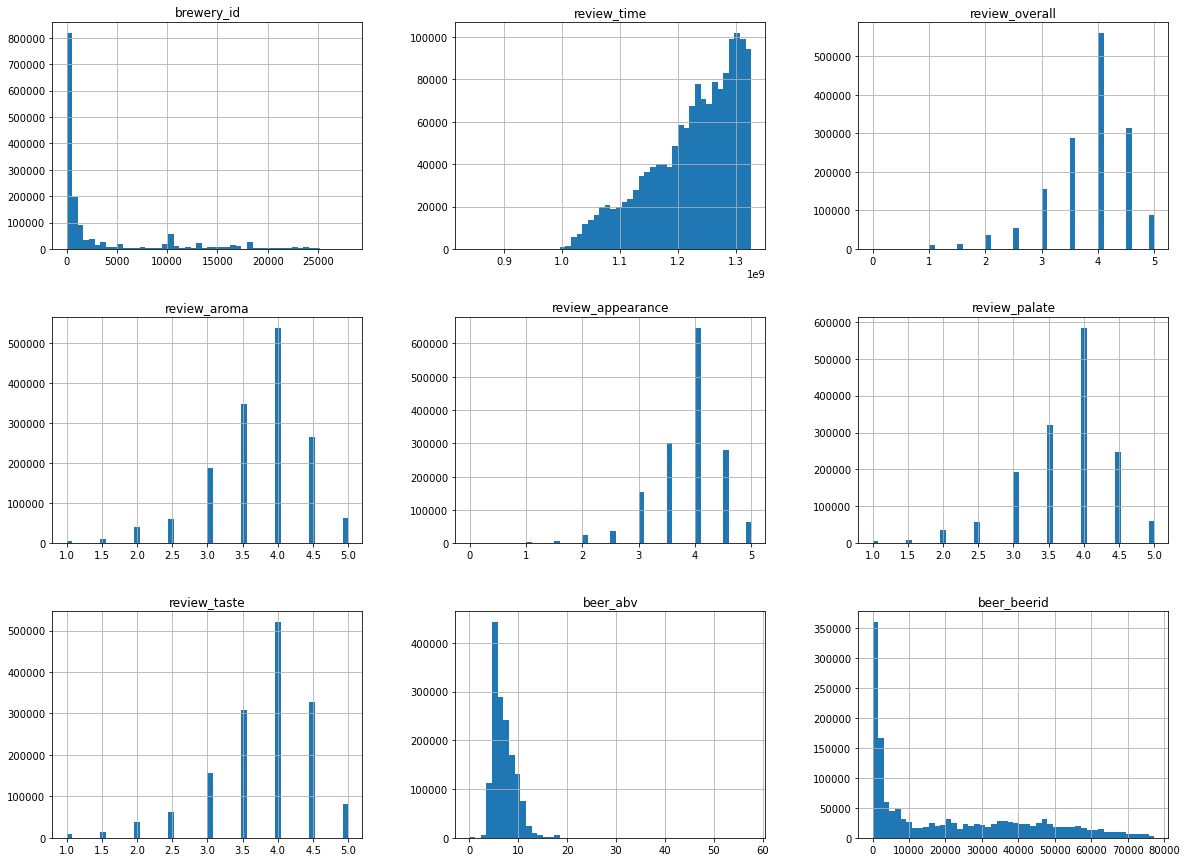

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303696 entries, 1565772 to 203078
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brewery_name        303696 non-null  object 
 1   review_overall      303696 non-null  float64
 2   review_aroma        303696 non-null  float64
 3   review_appearance   303696 non-null  float64
 4   review_profilename  303696 non-null  object 
 5   beer_style          303696 non-null  object 
 6   beer_name           303696 non-null  object 
dtypes: float64(3), object(4)
memory usage: 18.5+ MB
None
* Final recommended beers with beer style and brewer
* stcules 's review histories
                                    brewery_name  review_overall  \
968788               Brouwerij Duvel Moortgat NV             4.0   
1131963                              Ølfabrikken             4.5   
718778                              La Gastaldia             3.0   
747989               

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


def sort_best_beer_order(data, recommend_list):
    """
    sort dataSet by recommend list from parameter
    :param data: entire dataSet
    :param recommend_list: list of best beers to recommend
    :return: dataSet sorted by recommend list
    """

    # sort data in order of best beers obtained
    data = data.drop_duplicates(['beer_name'])
    df_sort = data[data['beer_name'].isin(recommend_list)].copy()
    sorterIndex = dict(zip(recommend_list, range(len(recommend_list))))

    # define new column for sorted by sorter index
    df_sort['sorter'] = df_sort['beer_name'].map(sorterIndex)

    # sort dataFrame based on sorter column
    df_sort.sort_values('sorter', inplace=True)
    # drop sorter column no longer needed
    df_sort.drop('sorter', axis=1, inplace=True)

    # return sorted entire dataFrame
    return df_sort


def get_user_profile(user_info, ohe):
    """
    get preference information by user's beer style based on review rating
    :param user_info: dataFrame for existing review data from user
    :param ohe: one-hot-encoded dataFrame for "beer style" on entire dataSet
    :return: normalized weight rating matrix of beer style of a user
    """

    user_rated_info = user_info[['review_overall']].to_numpy()

    # compute weighted beer style matrix by multiplying encoded matrix with user rating
    weighted = ohe.loc[user_info.index.values] * user_rated_info

    # get user profile information for beer style preference
    weighted_sum = weighted.sum(axis=0)  # sum all rows

    # normalize user profile using min-max scaling
    normalized_weighted_sum = (weighted_sum - weighted_sum.min()) / (weighted_sum.max() - weighted_sum.min())

    # return normalized weighted rating of user
    return normalized_weighted_sum


def recommend_content_based(data, user_name, num_c, num_b):
    """
    recommend beers using content-based recommendation system based on a user's history
    :param data: entire dataSet
    :param user_name: a string for user name from review data
    :param num_c: number of beer styles to recommend
    :param num_b: number of beers per beer style to recommend
    :return: final recommended beer name with beer style and brewery name
    """

    user = data[data['review_profilename'] == user_name]  # extract data from specific user
    print("*", user_name, "'s review histories")
    print(user, '\n')
    one_hot_encoded = pd.get_dummies(data['beer_style'])  # one-hot encoding based on beer style for entire dataSet
    data = data.drop(user.index.values)  # drop extracted user data from entire dataSet

    # get user profile for weight rating of beer style
    user_profile = get_user_profile(user, one_hot_encoded)

    # get best list beer style of user
    best_list = user_profile.sort_values(ascending=False).head(num_c)
    print('* Best beer styles to recommend for "', user_name, '"')
    print(best_list, '\n')
    # drop user data from encoded dataSet
    one_hot_encoded = one_hot_encoded.drop(user.index.values)
    # multiply all of beers with weight of beer style of user
    weighted_beer_matrix = one_hot_encoded.mul(user_profile)
    # compute sum of weighted beer matrix in descending based on column
    weighted_beer_sum = weighted_beer_matrix.sum(axis=1).sort_values(ascending=False)

    # get beer style, beer name and review rating according to weighted sum in a descending order
    result = data[['beer_style', 'beer_name', 'review_overall']].loc[weighted_beer_sum.index.values]

    recommendation_list = []  # list of best beer name for recommendation

    # fill beer list
    for i in range(num_c):  # number of beer styles
        for j in range(num_b):  # number of beers per beer styles

            # sort descending order based on the rating by averaging the beer name values for the highest weight rating
            recommendation_list.append(
                result[result['beer_style'] == best_list.index.values[i]].groupby('beer_name').mean().sort_values(
                    'review_overall', ascending=False).head(num_b).index.values.tolist()[j])

    print('* Best beers to recommend for "', user_name, '"')
    print(recommendation_list, '\n')
    # get sorted result ordered by best recommendation list
    sorted_result = sort_best_beer_order(data, recommendation_list)
    output_columns = ['brewery_name', 'beer_style', 'beer_name']

    # return final recommendation including brewery, beer style and beer name
    return sorted_result[output_columns]


def predict_rating(ratings_arr, item_sim_arr):
    ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred


# evaluation MSE only for the beers rated by the user
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)


def get_rmse(R, P, Q, non_zeros):
    # create prediction R matrix as inner product of two decomposed matrices P and Q.T
    full_pred_matrix = np.dot(P, Q.T)

    # extract the RMSE of the actual R matrix and the predicted matrix by extracting the position index of non-null values from the actual R matrix
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse


# matrix factorization function
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
    num_users, num_items = R.shape

    # specify the size of the P and Q matrices and input them as random values with normal distribution
    np.random.seed(1)
    P = np.random.normal(scale=1. / K, size=(num_users, K))
    Q = np.random.normal(scale=1. / K, size=(num_items, K))

    # store row, column position value for R > 0 in non_zeros list
    non_zeros = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

    # continuous update of P and Q matrix using SGD
    for step in range(steps):
        for i, j, r in non_zeros:
            # get error value that are the difference between actual value and predicted value
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # apply SGD formula reflecting Regularization
            P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
            Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0:
            print("### iteration step : ", step, " rmse : ", rmse)

    return P, Q


def recommend_item_based_neighbor_collaborative_filtering(data):
    user_info = data[['review_profilename']]
    print(user_info)
    beer_info = data[['beer_name']]
    print(beer_info)
    rating_info = data[['review_overall', 'review_aroma', 'review_appearance']]
    print(rating_info)

    concat_data = pd.concat([user_info, beer_info, rating_info], axis=1)

    user_rating = concat_data.drop_duplicates(['beer_name', 'review_profilename'])
    user_rating_pivot = user_rating.pivot(index='beer_name', columns='review_profilename',
                                          values='review_overall').fillna(0)

    user_rating_matrix = csr_matrix(user_rating_pivot.values)

    # KNN
    model_knn = NearestNeighbors(metric="cosine", algorithm="brute")
    model_knn.fit(user_rating_matrix)

    query_index = np.random.choice(user_rating_pivot.shape[0])
    print(user_rating_pivot.iloc[query_index, :])

    distances, indices = model_knn.kneighbors(user_rating_pivot.iloc[query_index, :].values.reshape(1, -1)
                                              , n_neighbors=6)
    print('Distances=', distances, 'Indices=', indices)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('recommendation for {0}:\n'.format(user_rating_pivot.index[query_index]))
        else:
            print('{0}: {1}, with distacne of {2}:'.format(i, user_rating_pivot.index[indices.flatten()[i]],
                                                           distances.flatten()[i]))

    user_rating_pivot.head()
    user_rating_matrix = user_rating.pivot_table('review_overall', index='review_profilename', columns='beer_name')
    user_rating_matrix = user_rating_matrix.fillna(0)
    user_rating_matrix.head(3)

    user_rating_matrix_t = user_rating_matrix.transpose()
    user_rating_matrix_t.head(3)

    item_sim = cosine_similarity(user_rating_matrix_t, user_rating_matrix_t)

    item_sim_df = pd.DataFrame(data=item_sim,
                               index=user_rating_matrix.columns,
                               columns=user_rating_matrix.columns)

    ratings_pred = predict_rating(user_rating_matrix.values, item_sim_df.values)
    ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=user_rating_matrix.index,
                                       columns=user_rating_matrix.columns)

    print('Item-based all neighbor MSE: ', get_mse(ratings_pred, user_rating_matrix.values))

    query_index = np.random.choice(user_rating_pivot.shape[0])

    user_rating_id = user_rating_pivot.iloc[query_index, :]

    # store beers that user has never tried before on an unseen list
    already_seen = user_rating_id[user_rating_id > 0].index.tolist()  # already_seen

    beer_list = user_rating_matrix.columns.tolist()
    unseen_list = [beer for beer in beer_list if beer not in already_seen]  # unseen_list

    recommen_beers = ratings_pred_matrix.iloc[query_index, :].sort_values(ascending=False)[:10]

    P, Q = matrix_factorization(user_rating_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01)
    pred_matrix = np.dot(P, Q.T)

    sgd_ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=user_rating_matrix.index,
                                           columns=user_rating_matrix.columns)
    sgd_ratings_pred_matrix.head(3)

    sgd_recommen_beers = sgd_ratings_pred_matrix.iloc[query_index, :].sort_values(ascending=False)[:10]
    return sgd_recommen_beers


# read dataSet
data = pd.read_csv('beer_reviews.csv')
print(data.head(5))
print(data.info())

# check whether dataset has missing value
print(data.isnull().sum())

# remove missing data
data = data.dropna()

# check missing data after dropping
print(data.isnull().sum())

# visualize for data exploration 
sns.heatmap(data.corr())
data.hist(bins=50, figsize=(20, 15))
plt.show()

# random sampling dataSet with extracting meaningful features
sampled_data = data[['brewery_name', 'review_overall', 'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
          'beer_name']].sample(frac=0.2, random_state=42)
print(sampled_data.info())

'''
Test data
'''
n = 3  # number of beer styles to recommend
m = 2  # number of beers per beer style to recommend
users = ['stcules', 'northyorksammy', 'zythus']  # target user's name to recommend

pd.set_option('display.max_columns', None)

# get list of beer recommendation of specific user
# print result
print('* Final recommended beers with beer style and brewer')

recommendation_result1 = recommend_content_based(sampled_data, users[0], n, m)
print('------ Recommendation for "', users[0], '"------')
print(recommendation_result1, '\n')

recommendation_result2 = recommend_content_based(sampled_data, users[1], n, m)
print('------ Recommendation for "', users[1], '"------')
print(recommendation_result2, '\n')

recommendation_result3 = recommend_content_based(sampled_data, users[2], n, m)
print('------ Recommendation for "', users[2], '"------')
print(recommendation_result3, '\n')


# get result for item-based collaborative filtering using knn & SGD
recommend_IBCF_result = recommend_item_based_neighbor_collaborative_filtering(sampled_data)
print('* Final recommendation result for item-based collaborative filtering')
print(recommend_IBCF_result)